In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

 ## Task

**Формулировка задачи:**

Обучить модель, которая будет искать в потоке новости с информацией о событии. Выбрать метрики, которые с вашей точки зрения будут наиболее релевантны для решаемой бизнес-задачи. Обосновать выбор метрик и модели.

**Целевая информация о событии** – задержка сдачи какого-либо объекта

**Data:**

`train_data.csv`

    - sentence - предложение, содержащее информацию
    - label - таргет
    
`test_data.csv`

    - title - заголовок новостей
    - text - текст статьи

Решаемая задача – бинарная классификация текстов.

Целевая метрика - **F1**. Учитывая, что в контексте задачи важно не пропустить положительный класс (исходя из логики, что итоговая цель задачи - определить платежеспособность компании заемщика), Recall является более важной метрикой ($\beta > 1$). Однако изменение важности Precision и Recall требует более углубленного анализа требуемых результатов, рисков и последствий, что невозможно в данном случае.

**План:**

- Загрузка предобработка данных

- EDA

- Использование базовых подходов по векторизации текста, исспользование classic ml

- Использование обученной русской BERT для получения эмбедингов предложений и обучение на них линейной модели

- Файнтюн XLM roberta для решения задачи бинарной классификации предложений

In [2]:
!pip install catboost
!pip install nltk pymorphy2 spacy optuna transformers
!pip install backports.tarfile
!pip install wordcloud==1.8.2.2
!spacy download ru_core_news_sm
!pip install pandarallel
!pip install deep_translator
!pip install peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 7.5 MB/s eta 0:00:00a 0:00:01


✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


In [1]:
import os
import re
import time
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandarallel import pandarallel
from tqdm.notebook import tqdm
tqdm.pandas()

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy2
import spacy
from wordcloud import WordCloud

import optuna
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.utils import resample, shuffle
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.utils.class_weight import compute_class_weight

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

from deep_translator import GoogleTranslator
from collections import Counter

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import transformers
from transformers import AutoTokenizer, AutoModel,RobertaTokenizer, RobertaModel, BertModel, BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification,XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, Trainer, TrainingArguments,DataCollatorForLanguageModeling
from transformers import LongformerModel, LongformerTokenizerFast, LongformerForSequenceClassification


from peft import PromptTuningConfig, get_peft_model, TaskType,PrefixTuningConfig

2024-08-07 11:02:00.973707: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
random_seed = 42
torch.manual_seed(0);

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))
morph = pymorphy2.MorphAnalyzer()
lemmatizer_spacy = spacy.load('ru_core_news_sm')
pandarallel.initialize(progress_bar=True);

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/matveyantonov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matveyantonov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## Загрузка данных

In [5]:
pth_train = 'data/train_data.csv'
pth_test = 'data/test_data.csv'



if os.path.exists(pth_train) and os.path.exists(pth_test):
    df_train = pd.read_csv(pth_train, index_col = 0)
    df_test = pd.read_csv(pth_test)

    df_test = df_test.drop(['Unnamed: 0', 'id'], axis = 1)
else:
    print('Something is wrong')

In [6]:
display(df_train.sample(10, random_state = random_seed))
display(df_test.sample(10, random_state = random_seed))

,sentence,label
941,"Тогда же, в марте 2019-го, региональные власти...",0
988,Общий бюджет стройки был увеличен на 10% до 38...,0
405,Однако местные власти не смогли найти подходящ...,0
722,Сама компания находится в стадии процедуры бан...,0
1614,Стройка будет идти за счет банковских кредитов.,0
135,Сейчас сроки сдачи задержаны более чем на полг...,1
1156,Квартиры до середины 2017 г. продавались слишк...,0
70,Но сроки сдачи отдельных участков дороги неодн...,1
342,"Как ранее сообщало ТюменьPRO, строительство аэ...",0
289,"Последний раз утверждали, что выдачу ключей бу...",1


,title,text
1284,Водители встали в пробки на подъездах к центру...,Общество Читатели сайта enisey.tv жалуются на ...
6992,Почему Зеленский готов окунуться в «Северный п...,С чего это украинский президент так кардинальн...
9622,За неделю с окончанием 29 ноября основные миро...,"АЗИАТСКО-ТИХООКЕАНСКИЙ РЕГИОН Nikkei 225 23,29..."
10063,В Роскосмосе назвали сильно преувеличенными сл...,"МОСКВА, 4 декабря. /ТАСС/. Роскосмос посчитал ..."
1393,Биржи США снижаются на обострении противоречий...,Биржи США снижаются на обострении противоречий...
10054,Арнетт Моултри отправился на просмотр в Китай,"Форвард Арнетт Моултри отправился в Китай, где..."
318,Россия начала поставки газа в Китай,Поставки российского газа в Китай по газопрово...
6925,Итоги образовательного проекта «Лето - 2019»,Организаторами Проекта стали министерство обра...
733,Сведения закупки,Общая информация о закупке Способ определени...
1509,Доставлен первый транзитный контейнер из Европ...,Он проследовал в тестовом режиме в рамках серв...


In [7]:
df_train.info()
print()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  1669 non-null   object
 1   label     1669 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 39.1+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10571 entries, 0 to 10570
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   10364 non-null  object
 1   text    10569 non-null  object
dtypes: object(2)
memory usage: 165.3+ KB


В данных присутствует дисбаланс. Также в тесте есть определенное колво пропусков

Только одна строчка имеет пропуски и в `title` и в `text`

In [10]:
df_test[(df_test['text'].isna())&(df_test['title'].isna())]

,title,text


Заполним пропуски пустой строкой6 чтобы не терять индексацию, которая вероятно важна при проверке предсказаний

In [8]:
df_test = df_test.fillna('')

In [9]:
df_train.duplicated().sum()

55

In [11]:
df_train = df_train.drop_duplicates().reset_index(drop=True)

In [12]:
df_train['label'].value_counts()

0    1301
1     313
Name: label, dtype: int64

В обучающих данных сильный дисбаланс классов

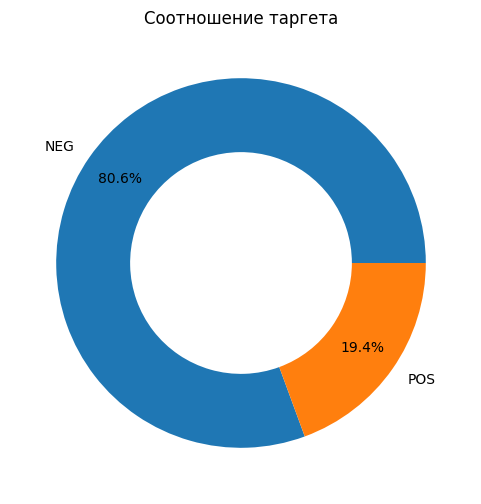

In [61]:
value_counts = df_train['label'].value_counts()
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(value_counts, labels=('NEG','POS'),pctdistance=0.8, autopct='%1.1f%%', wedgeprops=dict(width=0.4))
circle = plt.Circle((0, 0), 0.5, color='white')
ax.add_artist(circle)
ax.set_title("Cоотношение таргета")
plt.show()

___

<div style="border: 3px solid green; border-radius: 5px; padding: 10px;">

1) Тест содержит колонку с текстом статей, который более вероятно содержат информацию о задержке

2) Мало обучающих данных

2) В тесте есть пропуски, которые нужно учесть при предсказании

3) В трейне присутствует сильный дисбаланс классов (решение - синтетика, up/down, взвешивание классов)

## EDA

Лемматизируем данные для анализа

In [13]:
print(df_train[df_train['label'] == 0]['sentence'].iloc[10], end = '\n\n')
print(df_train[df_train['label'] == 1]['sentence'].iloc[10])

Решение проблемы затянулось, а пока все решалось, по настоянию депутатов людям временно разрешили торговать на тех местах, где они это делали раньше.

Работы были остановлены, заказчик начал судебную тяжбу, требуя, чтобы генподрядчик вернул все деньги, потраченные на несданный в срок завод.


In [14]:
def preprocessing_spacy(text):
    tokens = ' '.join(re.sub(r'[^а-я\' ]', ' ', text.lower()).split())
    tokens = lemmatizer_spacy(tokens)
    return " ".join([token.lemma_ for token in tokens if token.lemma_ not in stop_words])

def preprocessing_morph(text):
    tokens = ' '.join(re.sub(r'[^а-я\' ]', ' ', text.lower()).split())
    tokens = word_tokenize(tokens)
    return " ".join([morph.parse(token)[0].normal_form for token in tokens if morph.parse(token)[0].normal_form not in stop_words])

In [15]:
for text in df_train.sample(3,random_state=random_seed).loc[:,'sentence']:
    print(f'ORIG TEXT:\n\t {text}\n')
    print(f'PREPROC TEXT:')
    print(f'\tSpacy:\t {preprocessing_spacy(text)}')
    print(f'\tpymorph: {preprocessing_morph(text)}')
    print()

ORIG TEXT:
	 Открытие ЦКАД отложили до 2022 года.

PREPROC TEXT:
	Spacy:	 открытие цкад отложить год
	pymorph: открытие цкада отложить год

ORIG TEXT:
	 Но ни в декабре, ни в январе, ни в феврале, ни по сей день мы ничего не получили.

PREPROC TEXT:
	Spacy:	 декабрь январь февраль сей день ничто получить
	pymorph: декабрь январь февраль сей день получить

ORIG TEXT:
	 Сдан лишь один из трех домов.

PREPROC TEXT:
	Spacy:	 сдать лишь дом
	pymorph: сдать лишь дом



Будем использовать spacy

In [16]:
pth_train = 'data/train_lemma.csv'
pth_test = 'data/test_lemma.csv'

if os.path.exists(pth_train) and os.path.exists(pth_test):
    df_train['lemma'] = pd.read_csv(pth_train)['lemma']
    df_test[['lemma_title','lemma_text']] = pd.read_csv(pth_test)[['lemma_title','lemma_text']].fillna('')
else:
    df_train['lemma'] = df_train['sentence'].parallel_apply(preprocessing_spacy)
    df_test['lemma_title'] = df_test['title'].parallel_apply(preprocessing_spacy)
    df_test['lemma_text'] = df_test['text'].parallel_apply(preprocessing_spacy)
# df_train[['count_words','mean_word_len','special_symbols']] = df_train.progress_apply(add_features,axis=1).apply(pd.Series)

In [17]:
# df_train['lemma'].to_csv('train_lemma.csv',index=False)
# df_test[['lemma_title','lemma_text']].to_csv('test_lemma.csv',index=False)


In [18]:
display(df_train.head())
display(df_test.head())

,sentence,label,lemma
0,Срыв сроков строительства зоопарка оценили в 1...,1,срыв срок строительство зоопарк оценить млрд р...
1,"По данным Генпрокуратуры РФ, в 2014-2018 годах...",1,данным генпрокуратура рф год выявить тысяча ра...
2,"Обвиняли в этом столичный акимат, который сорв...",1,обвинять это столичный акимат который сорвать ...
3,Запуск циклотронного центра ядерной медицины н...,1,запуск циклотронный центр ядерный медицина баз...
4,Сроки сдачи объекта несколько раз переносились.,1,срок сдача объект несколько переноситься


,title,text,lemma_title,lemma_text
0,Графики обслуживания внутриквартирного и внутр...,В соответствии с п.42 Постановления Правительс...,график обслуживание внутриквартирный внутридом...,соответствие п постановление правительство рф ...
1,На МЦД улучшили поезда,"В Москве, на Белорусско-Савеловском центрально...",мцд улучшить поезд,москва белорусско савёловский центральный диам...
2,Катастрофа SSJ 100: вина за гибель 41 человека...,Завершено расследование дела о крушении самоле...,катастрофа вино гибель человек возложить пилот,завершить расследование дело крушение самолёт ...
3,С Днем юриста!,От души поздравляем сотрудников и преподавател...,день юрист,душа поздравлять сотрудник преподаватель студе...
4,"Охота на ""черного"" лесоруба","В Костроме прошел межрегиональный форум, посвя...",охота чёрный лесоруб,костроме пройти межрегиональный форум посвятит...


Взглянем на распределения количества слов, предложений и длин слов

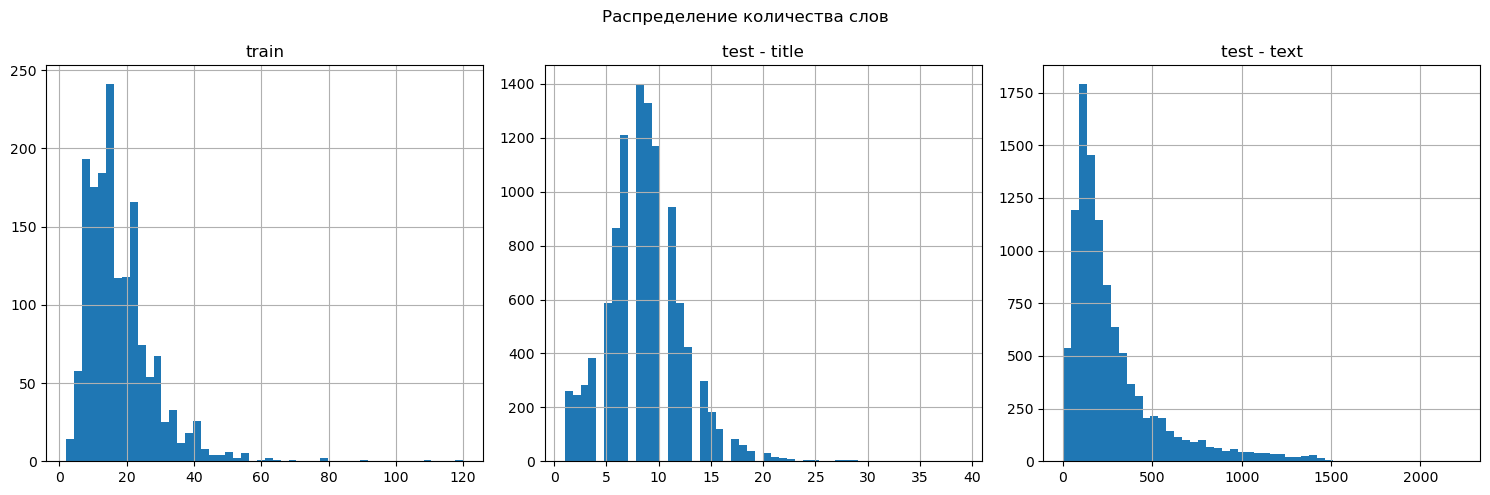

In [19]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
df_train['sentence'].apply(lambda x: len(x.split(' '))).hist(bins=50)
plt.title('train')
plt.subplot(1, 3, 2)
df_test['title'].apply(lambda x: len(str(x).split(' '))).hist(bins=50)
plt.title('test - title')
plt.subplot(1, 3, 3)
df_test['text'].apply(lambda x: len(str(x).split(' '))).hist(bins=50)
plt.title('test - text')
plt.suptitle('Распределение количества слов')
plt.tight_layout()
plt.show()

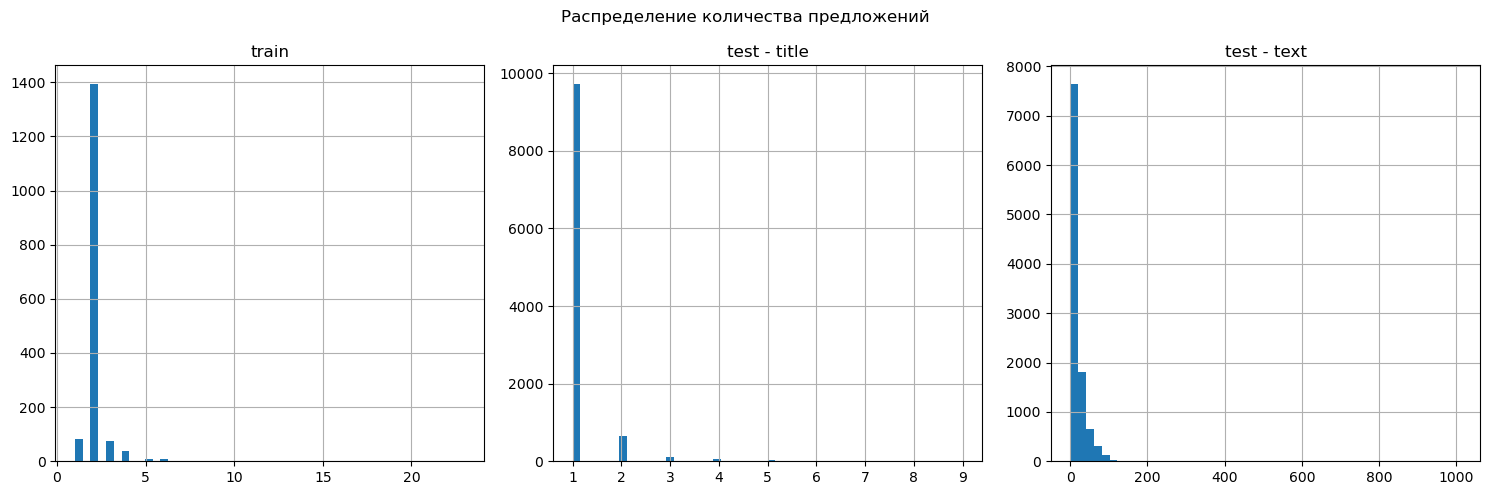

In [20]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
df_train['sentence'].apply(lambda x: len(x.split('.'))).hist(bins=50)
plt.title('train')
plt.subplot(1, 3, 2)
df_test['title'].apply(lambda x: len(str(x).split('.'))).hist(bins=50)
plt.title('test - title')
plt.subplot(1, 3, 3)
df_test['text'].apply(lambda x: len(str(x).split('.'))).hist(bins=50)
plt.title('test - text')
plt.suptitle('Распределение количества предложений')
plt.tight_layout()
plt.show()

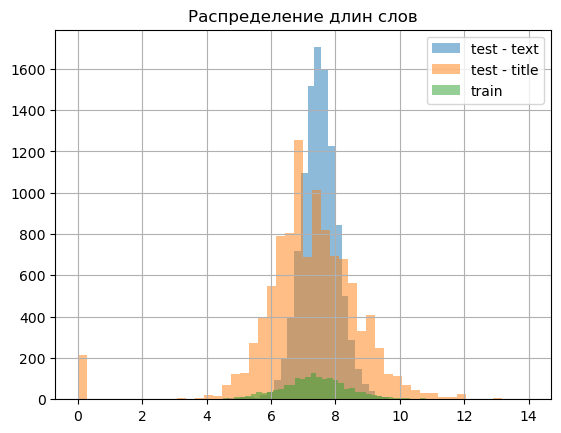

In [22]:
def mean_word_count(val):
    val_split = val.split(' ')
    return len(''.join(val_split))/len(val_split)

df_test['lemma_text'].apply(mean_word_count).hist(bins=50,label = 'test - text', alpha = 0.5)
df_test['lemma_title'].apply(mean_word_count).hist(bins=50,label = 'test - title', alpha = 0.5)
df_train['lemma'].apply(mean_word_count).hist(bins=50,label = 'train', alpha = 0.5)
plt.title('Распределение длин слов')
plt.legend()
plt.show()

Обучающая выборка содержит предложения длиннее чем столбец `title` и короче чем столбец `text` в тестовой выборке

Поссмотрим на частоту появления слов в каждом классе

In [30]:
text_cloud_0 = ''
text_cloud_1 = ''
all_text = ''
for i, text in enumerate(df_train['lemma'].values):
    try:
        all_text+= ' '+text
        if df_train['label'].iloc[i] == 0:
            text_cloud_0+= ' '+text
        else:
            text_cloud_1+= ' '+text
    except:
        print(text)

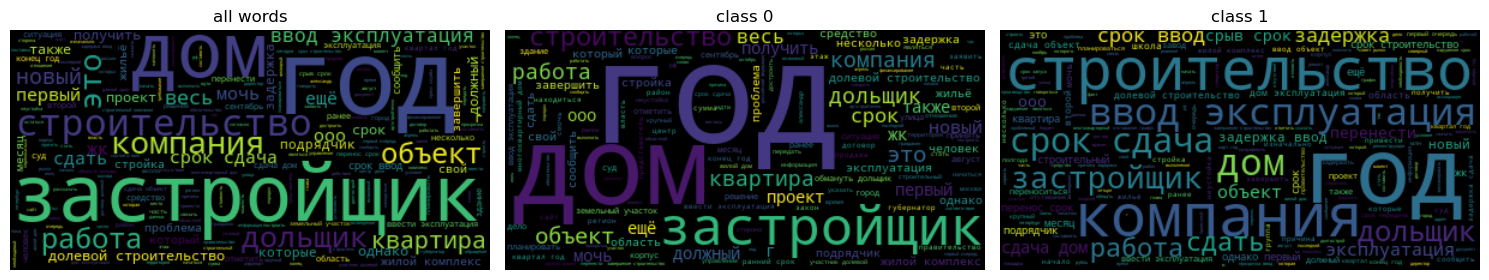

In [31]:
wordcloud = WordCloud().generate(all_text)
wordcloud_0 = WordCloud().generate(text_cloud_0)
wordcloud_1 = WordCloud().generate(text_cloud_1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('all words')
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.title('class 0')
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.title('class 1')
plt.axis("off")
plt.tight_layout()
plt.show()

Посмотрим на топ частых слов в классах

In [33]:
def freq(df):
    combined_text = ' '.join(df)
    words = combined_text.split()
    word_freq = Counter(words)
    return word_freq

In [34]:
fr0 = pd.DataFrame(freq(df_train[df_train['label']==0]['lemma']).items()).sort_values(by=[1], ascending=False).reset_index(drop=True)
fr1 = pd.DataFrame(freq(df_train[df_train['label']==1]['lemma']).items()).sort_values(by=[1], ascending=False).reset_index(drop=True)
fr0[1] = fr0[1]/fr0[1].sum() * 100
fr1[1] = fr1[1]/fr1[1].sum() * 100

In [35]:
multi_index = pd.MultiIndex.from_tuples((('fr_0','word'),('fr0','freq'),('fr_1','word'),('fr1','freq')))
fr_df = pd.concat([fr0,fr1],axis=1).head(20)
fr_df.columns = multi_index
fr_df

,fr_0,fr0,fr_1,fr1
,word,freq,word,freq
0,год,1.807191,срок,3.722436
1,строительство,1.549021,год,2.629982
2,дом,1.511240,эксплуатация,2.164677
3,застройщик,1.083055,строительство,2.023063
4,срок,0.969712,дом,1.942140
5,объект,0.950822,ввод,1.820757
6,дольщик,0.850072,сдача,1.375683
7,компания,0.749323,задержка,1.375683
8,работа,0.736729,объект,1.132915


Группы пересекаются, посмотрим на количество пересечений топ-К слов

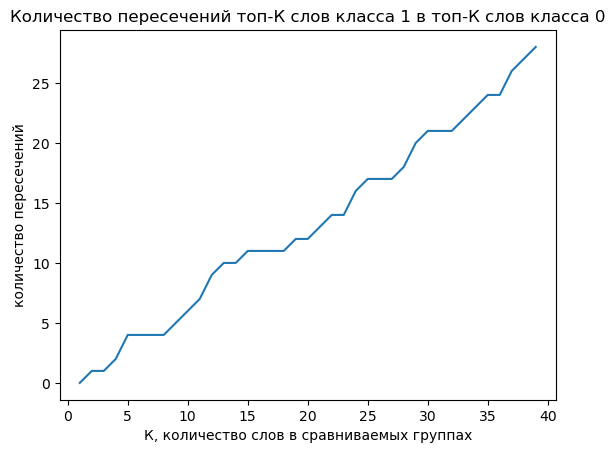

In [36]:
def count_matching_words(list1, list2):
    return len(set(list1).intersection(set(list2))) # смотрим количество пересечений топ-к слов класса 1 в классе 0
n = 40
match = []
for i in range(1,n):
    match.append(count_matching_words(fr1.iloc[:i,0].to_list(),fr0.iloc[:i,0].to_list())) # берем срез каждого класса

plt.plot(np.arange(1,n),match)
plt.title('Количество пересечений топ-К слов класса 1 в топ-К слов класса 0')
plt.xlabel('К, количество слов в сравниваемых группах')
plt.ylabel('количество пересечений')
plt.axis('equal')
plt.show()

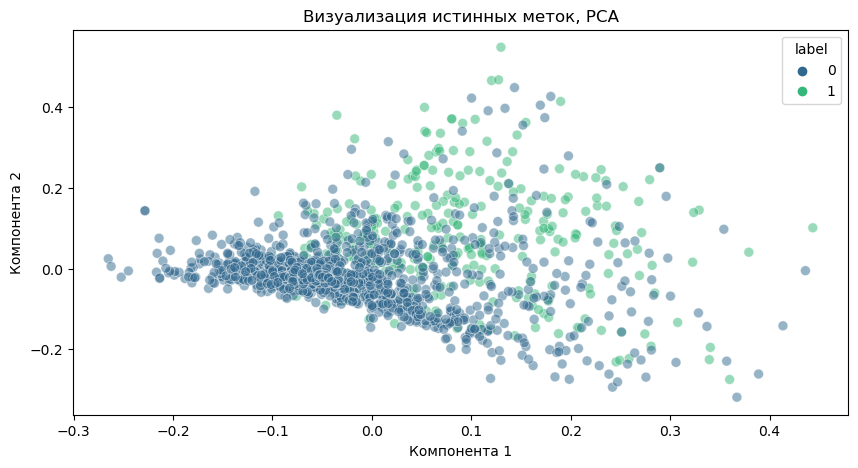

In [37]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X_tfidf = tfidf_vectorizer.fit_transform(df_train['lemma'])

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(10, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_train['label'], palette='viridis', s=50,alpha=0.5)
plt.title('Визуализация истинных меток, PCA')
plt.xlabel('Компонента 1')
plt.ylabel('Компонента 2')
plt.show()

нет явных разделений

___

<div style="border: 3px solid green; border-radius: 5px; padding: 10px;">
    
- Данный были очищены и лемматизированы через spacy.
    
- Было замечено, что данные в трейне длиннее чем в `title` и короче чем в`text` в тесте
    
- самые частые слова всстречаются как в тесте, так и в трейне

## обучение

###  Classic ML

In [38]:
X = df_train.drop(['sentence','label'],axis=1)
y = df_train['label']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_seed, stratify=y)

In [ ]:
transform_col = ColumnTransformer([
#     ("vectorize", CountVectorizer(ngram_range=(1, 2)), 0)
    ("vectorize", TfidfVectorizer(ngram_range=(1, 1)), 0)
])

In [ ]:
stratified_kfold = StratifiedKFold(n_splits = 3, shuffle = True, random_state = random_seed)

In [ ]:
%%time
pipe = imPipeline(steps=[
    ('transformer',transform_col),
    ("upsampler", RandomUnderSampler(random_state = random_seed)),
    ('classifier', LogisticRegression(random_state = random_seed, solver="liblinear", class_weight='balanced')),
])

params_rougher = {
        'classifier__max_iter': [100, 200, 500],
        'classifier__C': [0.1, 1, 10],
}

grid_rougher = GridSearchCV(pipe, param_grid=params_rougher, cv=stratified_kfold, n_jobs=-1,scoring='f1')
reg_model = grid_rougher.fit(X_train, y_train)
best_params = grid_rougher.best_params_
best_score = grid_rougher.best_score_
print("Best Parameters:", best_params)
print("Best F1:", best_score)

Best Parameters: {'classifier__C': 1, 'classifier__max_iter': 100}
Best F1: 0.6238458090118892
CPU times: user 209 ms, sys: 271 ms, total: 481 ms
Wall time: 3.9 s


In [ ]:
%%time
pipe = imPipeline(steps=[

    ('transformer',transform_col),
    ("upsampler", RandomUnderSampler(random_state = random_seed)),
    ('classifier', SVC(random_state=random_seed, class_weight='balanced')),
])

params_rougher = {
    'classifier__max_iter': [10000],
    'classifier__C': [0.1, 1, 5, 10],
    'classifier__kernel': ['linear', 'rbf', 'poly']
}

grid_rougher = GridSearchCV(pipe, param_grid=params_rougher, cv=stratified_kfold, n_jobs=-1,scoring='f1')
svm_model = grid_rougher.fit(X_train, y_train)
best_params = grid_rougher.best_params_
best_score = grid_rougher.best_score_
print("Best Parameters:", best_params)
print("Best F1:", best_score)

Best Parameters: {'classifier__C': 10, 'classifier__kernel': 'rbf', 'classifier__max_iter': 10000}
Best F1: 0.6260556366247423
CPU times: user 191 ms, sys: 37.8 ms, total: 229 ms
Wall time: 775 ms


In [ ]:
%%time
pipe = imPipeline(steps=[
    ('transformer',transform_col),
    ("upsampler", RandomOverSampler(random_state = random_seed)),
    ('classifier', RandomForestClassifier(n_jobs = -1, random_state = random_seed))
])

params_rougher = {
        'classifier__max_depth': range(10,20),
        'classifier__n_estimators': [150,200]
}

grid_rougher = GridSearchCV(pipe, param_grid=params_rougher, cv=stratified_kfold, n_jobs=-1,scoring='f1')
forest_model = grid_rougher.fit(X_train, y_train)
best_params = grid_rougher.best_params_
best_score = grid_rougher.best_score_
print("Best Parameters:", best_params)
print("Best F1:", best_score)

Best Parameters: {'classifier__max_depth': 15, 'classifier__n_estimators': 200}
Best F1: 0.6427846991522851
CPU times: user 999 ms, sys: 203 ms, total: 1.2 s
Wall time: 8.35 s


In [ ]:
%%time
pipe = imPipeline(steps=[
#     ("upsampler", RandomUnderSampler(random_state=random_seed)),
    ('transformer', transform_col),
    ("upsampler", RandomOverSampler(random_state=random_seed)),
#     ('upsampler', SMOTE(random_state=random_seed)),
    ('classifier', CatBoostClassifier(random_seed=random_seed,
                                      verbose=0))#, class_weights=class_weights_dict))
])

params_rougher = {
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__n_estimators': [150, 200, 250],
    'classifier__max_depth': [1, 2, 3, 4],
}


grid_rougher = GridSearchCV(pipe, param_grid=params_rougher, cv=stratified_kfold, n_jobs=-1, scoring='f1')
catboost_model = grid_rougher.fit(X_train, y_train)
best_params = grid_rougher.best_params_
best_score = grid_rougher.best_score_
print("Best Parameters:", best_params)
print("Best F1:", best_score)

Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 1, 'classifier__n_estimators': 250}
Best F1: 0.6439128001372941
CPU times: user 1.64 s, sys: 255 ms, total: 1.89 s
Wall time: 15.7 s


Катбуст и лес показали лучший результат

In [ ]:
def train_valid_predict(model, plot=False, features=X_test, target=y_test, sample_type='test', threshold = None):
    if threshold is None:
        predict = model.predict(features)
    else:
        predict = (model.predict_proba(features)[:, 1] > threshold).astype(int)
    accuracy_valid = accuracy_score(target, predict)
    f1 = f1_score(target, predict)

    precision = precision_score(target, predict, average=None)
    recall = recall_score(target, predict, average=None)

    if threshold is not None:
        proba = model.predict_proba(features)
        roc_auc = roc_auc_score(target, proba[:, 1])

    print(f'Metrics on {sample_type}')
    print("----------------------------------------------------------")
    print(f'Accuracy ___________: {accuracy_valid:.4f}')
    print(f'F1 _________________: {f1:.4f}')
    if threshold is not None:
        print(f'ROC-AUC ____________: {roc_auc:.4f}')
    print()
    print(f'{"":<21}Class {0}:{"":<8}Class {1}:')
    print()
    print(f'Precision :{"":<10} {precision[0]:.4f}{"":<10}{precision[1]:.4f}')
    print(f'Recall    :{"":<10} {recall[0]:.4f}{"":<10}{recall[1]:.4f}')
    print("----------------------------------------------------------")

    if plot and threshold is not None:
        fpr, tpr, thresholds = roc_curve(target,  proba[:, 1])

        fig = plt.figure(figsize=(8, 4))
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)

        ax1.plot(fpr, tpr)
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title('ROC Curve')

        group_names = ['True Neg','False Pos','False Neg','True Pos']
        cm = confusion_matrix(target, predict)
        group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        sns.heatmap(cm, annot=labels, fmt='', cmap='Blues',ax=ax2);


        plt.show()

Metrics on test
----------------------------------------------------------
Accuracy ___________: 0.8700
F1 _________________: 0.7123
ROC-AUC ____________: 0.9163

                     Class 0:        Class 1:

Precision :           0.9542          0.6265
Recall    :           0.8808          0.8254
----------------------------------------------------------


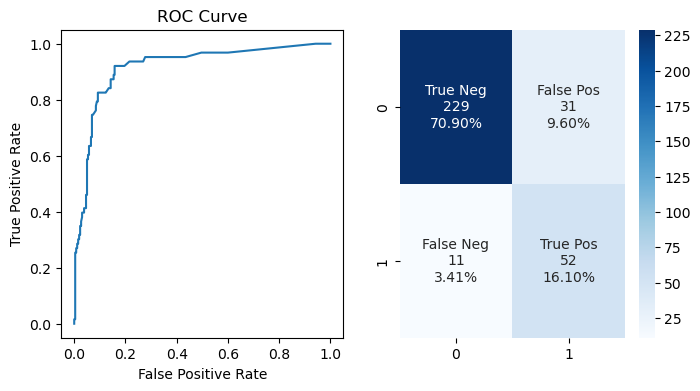

In [ ]:
train_valid_predict(catboost_model,features=X_test, target=y_test, threshold = 0.5, plot = True)

Metrics on test
----------------------------------------------------------
Accuracy ___________: 0.8669
F1 _________________: 0.6614
ROC-AUC ____________: 0.9191

                     Class 0:        Class 1:

Precision :           0.9189          0.6562
Recall    :           0.9154          0.6667
----------------------------------------------------------


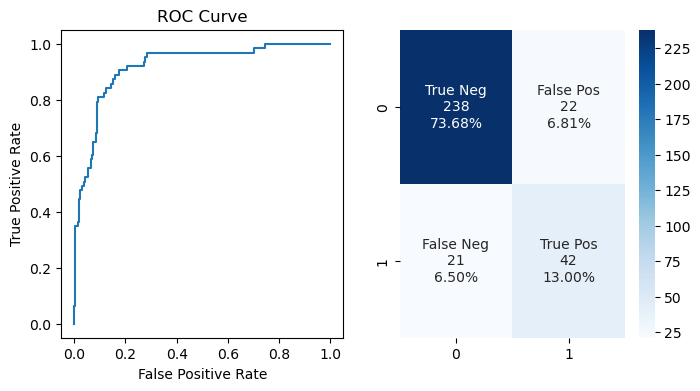

In [ ]:
train_valid_predict(forest_model,features=X_test, target=y_test, threshold = 0.5, plot = True)

У леса Recall в разы ниже чем у бустинга. В разделе classic ML оставим только **бустинг**

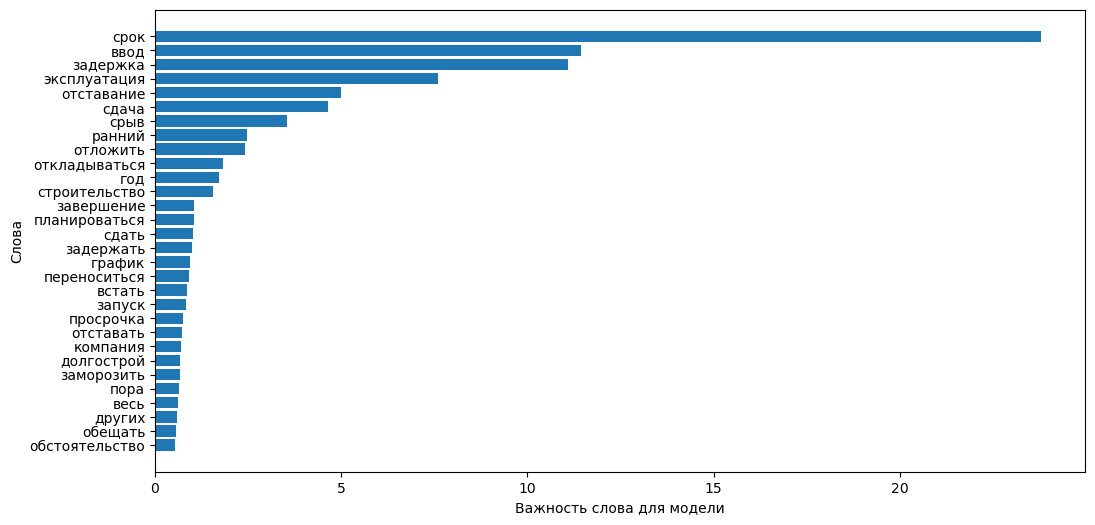

In [ ]:
cat_vectorize = catboost_model.best_estimator_.named_steps['transformer'].named_transformers_['vectorize']
voc = cat_vectorize.get_feature_names_out()
coefficients = catboost_model.best_estimator_.named_steps['classifier'].get_feature_importance()

word_importance = [(word, coef) for word, coef in zip(voc, coefficients)]
word_importance.sort(key=lambda x: abs(x[1]), reverse=True)
x = [x[0] for x in word_importance[:30]]
y = [x[1] for x in word_importance[:30]]
plt.figure(figsize=(12, 6))
plt.barh(range(len(x)), y, align='center')
plt.yticks(range(len(x)), x)
plt.xlabel('Важность слова для модели')
plt.ylabel('Слова')
plt.gca().invert_yaxis()
plt.show()

Из важности признаков видно, что для модели важнеее всего наличие слова `срок`, которое является самым часто употребляемым в классе 1. Однако это слово также входит в топ 5 по частоте в классе 0, что негативно сказывается на Precision.

Прогоним тестовые данные через катбуст

In [ ]:
df_test_lemma = pd.DataFrame(df_test['lemma_title'])
df_test_lemma.columns = ['lemma']
df_test['pred'] = catboost_model.predict(df_test_lemma)

In [ ]:
len(df_test[df_test['pred']==1]['title'].to_list())

54

In [ ]:
df_test[df_test['pred']==1]['title'].head(10).to_list()

['В Свердловской области отложат ввод налога для самозанятых',
 '«Московский Диснейленд» не уложился в сроки // Окупится ли тематический парк аттракционов «Остров мечты»',
 'Назван срок окончания добычи легендарной нефти',
 'Подполковник не управился со взяткой // Имущественные отношения с Минобороны оценили в миллионах и сроках',
 'В «Титановой долине» сорваны сроки строительства здания таможни',
 'Новый выпуск: Эмитент Macquarie Bank разместил еврооблигации (US55608RBD17) на сумму USD 520.0 млн со сроком погашения в 2021 году',
 'Срок уплаты имущественных налогов истекает 2 декабря',
 'NEWSru.com :: Расследование авиакатастрофы SSJ 100 в Шереметьево завершилось в рекордные сроки, единственным виновным назван пилот',
 'Реконструкция очистных сооружений в Рефтинском откладывается на год',
 'Новый выпуск: Эмитент Avia Solutions Group разместил еврооблигации (XS2010038573) со ставкой купона 7.875% на сумму USD 300.0 млн со сроком погашения в 2024 году']

На примере `NEWSru.com :: Расследование авиакатастрофы SSJ 100 в Шереметьево завершилось в рекордные сроки, единственным виновным назван пилот` видно, что большой вклад вносит слово `срок`, которое в данном случае привело к неправильному прогнозу.

Прогоним `text`

In [ ]:
df_test_lemma = pd.DataFrame(df_test['lemma_text'])
df_test_lemma.columns = ['lemma']
df_test['pred'] = catboost_model.predict(df_test_lemma)

In [ ]:
len(df_test[df_test['pred']==1]['title'].to_list())

141

Проверим на результат через `title`

In [ ]:
df_test[df_test['pred']==1]['title'].head(10).to_list()

['«УКС города Иркутска» проектирует новые дома на улице Лыткина',
 'Назначение мирового судьи',
 'Парк Победы после благоустройства станет одной из красивых территорий столицы Калмыкии',
 'Голубев выяснял, почему затянули реконструкцию трамвайных путей в Новочеркасске',
 'Губернатор призвал не снижать заявленных темпов достройки домов',
 'Сбербанк привлекает клиентов новогодними вкладами с\xa0повышенной ставкой',
 'В\xa0США\xa0рассказали о\xa0вариантах продления СНВ-3',
 'Прокуратура намерена обжаловать приговор суда в отношении взяточника',
 'Текущую из щелей воду на «Дунайской» собирают тряпками',
 'В «Титановой долине» сорваны сроки строительства здания таможни']

In [ ]:
df_test[df_test['pred']==1]['text'].iloc[5]

'Иллюстрация: ugra-news.ru Сбербанк запустил два сезонных вклада с\xa0повышенными ставками для розничных клиентов. Как сообщила пресс-служба банка, продукты получили названия «Новогодний бонус» и\xa0«Выгодный старт». Вклад «Новогодний бонус» можно открыть до\xa015\xa0января 2020 года включительно, ставка при сроке от\xa0четырех до\xa0девяти месяцев составит 4,85% годовых, на\xa0срок девять месяцев\xa0- 5,25%. Вклад «Выгодный старт» можно открыть до\xa031\xa0января 2020 года включительно, ставка при сроке шесть месяцев составит 5,00%, на\xa0срок один год\xa0- 5,50%, на\xa0срок полтора года\xa0- 5,85%. При этом «Выгодный старт» доступен только новым вкладчикам банка, которые в\xa0период с\xa020\xa0октября 2018 года по\xa020\xa0ноября 2019 года не\xa0открывали в\xa0нем срочные вклады. Минимальная сумма обоих депозитов\xa0- 50\xa0тыс.\xa0руб., вклады не\xa0пополняемые. Как сообщало EADaily, ранее было отмечено снижение средней максимальной ставки по\xa0вкладам десяти банков РФ, привлекающи

Вероятно, в данном случае модель также обратила внимание на `срок` и ошиблась

_____________


<div style="border: 3px solid green; border-radius: 5px; padding: 10px;">

Использование Count-based подходов к векторизации не позволяет достичь хорошего качества предсказания. Модель берет во внимание определнные слова, которые встречаются как в трейне так и в тесте.

Лучший результат - catboost:

F1 _______: 0.7123

Precision_:            0.6265
    
Recall____:             0.8254

### data -> bert -> embeddings -> logreg

Данный подход заключается в подготовке эмбедингов через обученную bert и обучении на них линейной модели

In [ ]:
def preprocess_for_bert(val):
    val = re.sub(r'[^а-я\'\s]', ' ', val.lower())
#     val = re.sub(r'[^а-я\s\'\-.,!?]', ' ', val.lower())
    val = re.sub(r'\s+', ' ', val).strip()
    return val

In [ ]:
model_name = "cointegrated/rubert-tiny2"
# model_name = 'DeepPavlov/rubert-base-cased'
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModel.from_pretrained(model_name)

In [ ]:
def embed_bert_cls(text, model, tokenizer, max_length):
    t = tokenizer(text, max_length = max_length, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

print(embed_bert_cls('привет мир', model, tokenizer,max_length=1024).shape)

(312,)


In [ ]:
X = df_train['sentence'].apply(preprocess_for_bert).apply(preprocess_for_bert).progress_apply(lambda x: embed_bert_cls(x, model, tokenizer,max_length=1024))
X_test_bert_title = df_test['title'].apply(preprocess_for_bert).apply(preprocess_for_bert).progress_apply(lambda x: embed_bert_cls(x, model, tokenizer,max_length=1024))
X_test_bert_text = df_test['text'].apply(preprocess_for_bert).apply(preprocess_for_bert).progress_apply(lambda x: embed_bert_cls(x, model, tokenizer,max_length=1024))

  0%|          | 0/1614 [00:00<?, ?it/s]

  0%|          | 0/10571 [00:00<?, ?it/s]

  0%|          | 0/10571 [00:00<?, ?it/s]

/Users/matveyantonov/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/matveyantonov/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/matveyantonov/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/matveyantonov/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/matveyantonov/opt/anaconda3/lib/python3.8

/Users/matveyantonov/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/matveyantonov/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/matveyantonov/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/matveyantonov/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/matveyantonov/opt/anaconda3/lib/python3.8

/Users/matveyantonov/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/matveyantonov/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/matveyantonov/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/matveyantonov/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/matveyantonov/opt/anaconda3/lib/python3.8

In [ ]:
X = np.array(X.tolist())
y = df_train['label']

In [ ]:
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(X, y, test_size=0.2, random_state = random_seed, stratify=y)

In [ ]:
%%time
pipe = imPipeline(steps=[
    ("upsampler", RandomOverSampler(random_state = random_seed)),
    ('classifier', LogisticRegression(random_state = random_seed, solver="liblinear", class_weight='balanced')),
])

params_rougher = {
        'classifier__max_iter': [200, 300, 500],
        'classifier__C': [0.1, 1, 5, 10],
}

grid_rougher = GridSearchCV(pipe, param_grid=params_rougher, cv=stratified_kfold, n_jobs=-1,scoring='f1')
reg_model = grid_rougher.fit(X_train_bert, y_train_bert)
best_params = grid_rougher.best_params_
best_score = grid_rougher.best_score_
print("Best Parameters:", best_params)
print("Best F1:", best_score)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Best Parameters: {'classifier__C': 5, 'classifier__max_iter': 200}
Best F1: 0.6136142400222501
CPU times: user 321 ms, sys: 283 ms, total: 604 ms
Wall time: 3.84 s


In [ ]:
%%time
pipe = imPipeline(steps=[
    ("upsampler", RandomOverSampler(random_state = random_seed)),
    ('classifier', SVC(random_state=random_seed, class_weight='balanced',probability=True)),
])

params_rougher = {
    'classifier__max_iter': [100,200,500],
    'classifier__C': [0.1, 1, 5, 10],
    'classifier__kernel': ['linear', 'rbf', 'poly']
}

grid_rougher = GridSearchCV(pipe, param_grid=params_rougher, cv=stratified_kfold, n_jobs=-1,scoring='f1')
svm_model = grid_rougher.fit(X_train_bert, y_train_bert)
best_params = grid_rougher.best_params_
best_score = grid_rougher.best_score_
print("Best Parameters:", best_params)
print("Best F1:", best_score)

Best Parameters: {'classifier__C': 1, 'classifier__kernel': 'poly', 'classifier__max_iter': 200}
Best F1: 0.6573067494355508
CPU times: user 1.08 s, sys: 67.8 ms, total: 1.15 s
Wall time: 25.5 s


/Users/matveyantonov/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Metrics on test
----------------------------------------------------------
Accuracy ___________: 0.8545
F1 _________________: 0.5913
ROC-AUC ____________: 0.8846

                     Class 0:        Class 1:

Precision :           0.8930          0.6538
Recall    :           0.9308          0.5397
----------------------------------------------------------


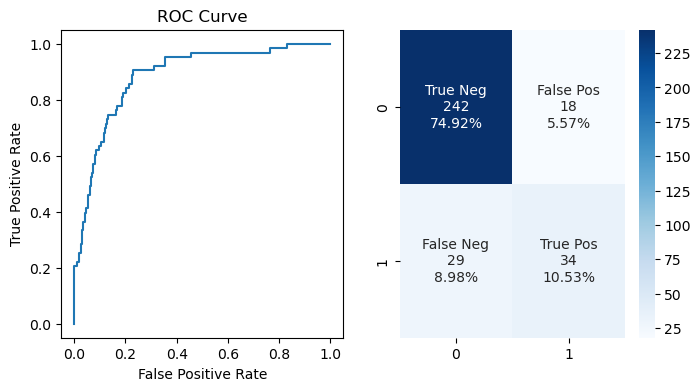

In [ ]:
train_valid_predict(svm_model,features=X_test_bert, target=y_test_bert, threshold = 0.5, plot = True)

Прогоним тестовые данные через svc

In [ ]:
df_test['pred'] = svm_model.predict(np.array(X_test_bert_title.tolist()))

In [ ]:
len(df_test[df_test['pred']==1]['title'].to_list())

34

In [ ]:
df_test[df_test['pred']==1]['title'].head(10).to_list()

['В «Титановой долине» сорваны сроки строительства здания таможни',
 'Прерванное три года назад строительство учебного центра МЧС в Иванове возобновят',
 'Подрядчик строительства "Восточного" приговорен к 11 годам заключения',
 'Один долгострой и несколько торговых центров сдали во Владивостоке в 2019 году',
 'Один долгострой и несколько торговых центров сдали во Владивостоке в 2019 году',
 'Новогодняя распродажа в Лаборатории «Гемотест»',
 'В Пермском крае строительство межпоселкового газопровода от села Шлыки до села Богомяково идет с опережением графика на полгода',
 'Узнали, ждать ли петрозаводчанам продуктового магазина вместе Спара в «Макси»',
 'Первый этап капитального ремонта школы № 2 г. Грязовца завершен',
 'Власти Москвы готовы избавиться еще от двух долгостроев']

Прогоним `text`

In [ ]:
df_test['pred'] = svm_model.predict(np.array(X_test_bert_text.tolist()))

In [ ]:
len(df_test[df_test['pred']==1]['title'].to_list())

80

Проверим на результат через `title`

In [ ]:
df_test[df_test['pred']==1]['title'].head(10).to_list()

['Путин и Си Цзиньпин 2 декабря запустят газопровод «Сила Сибири»',
 'Дан старт поставкам газа по «Силе Сибири»',
 'Губернатор призвал не снижать заявленных темпов достройки домов',
 'Плановое отключение электроэнергии',
 'В «Титановой долине» сорваны сроки строительства здания таможни',
 'Смольный уперся в землю',
 'Карабулакская городская газета',
 'В компании "Ак Барс" не считают себя причастными к финансовому краху "КамгэсЗЯБа", что противоречит заявлениям руководства предприятия',
 'Безальтернативные турбины // Кировский завод поставит установки для новых ледоколов Балтийского завода',
 'В Пермском крае строительство межпоселкового газопровода от села Шлыки до села Богомяково идет с опережением графика на полгода']

___

<div style="border: 3px solid green; border-radius: 5px; padding: 10px;">

Эмбединги предобученной Bert не позволяют улучшить качество. Для эмбедингов рассматривались разные ruBERT/ruroBERTa, лучший результат показала - ruBERT tiny

Лучший результат:

F1 _______: 0.5913

Precision_: 0.6538
    
Recall____: 0.5397


### Finetune BERT/RoBERTa/XLM_roBERTA

In [19]:
def back_translate(text, src_lang='ru', mid_lang='en'):
    translated = GoogleTranslator(source=src_lang, target=mid_lang).translate(text)
    back_translated = GoogleTranslator(source=mid_lang, target=src_lang).translate(translated)
    return back_translated

def random_swap(text):
    words = text.split()
    if len(words) > 1:
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)


def augment_text(text, method='translate'):
    if method == 'translate':
        text = back_translate(text)
    elif method == 'random_swap':
        aug = naw.RandomWordAug(action='swap')
        text = aug.augment(text)
    else:
        raise ValueError("Unsupported augmentation method")

    return text


In [20]:
class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, device, augmentation_prob=0.2, augmentation_methods=None):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe['sentence']
        self.labels = dataframe['label']
        self.max_len = max_len
        self.device = device

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()

        label = torch.tensor(self.labels[index], dtype=torch.long)
        return {
            'input_ids': input_ids.to(device),
            'attention_mask': attention_mask.to(device),
            'label': label.to(device),
            # 'orig': text
        }

class TextDatasetTest(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, device):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe['text']
        self.index = dataframe['index']
        self.max_len = max_len
        self.device = device


    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = self.text[index]
        i_index = self.index[index]

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()

        return {
            'input_ids': input_ids.to(device),
            'attention_mask': attention_mask.to(device),
            'index': i_index,
            'orig_text':text
        }


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [40]:
torch.cuda.empty_cache()

In [33]:
X_train, X_test = train_test_split(df_train, test_size=0.2, random_state = 42, stratify=df_train['label'])

In [22]:
gen_X = pd.read_csv('train_data_gen.csv', index_col = 0)
trans_X = pd.read_csv('translate.csv', index_col = 0)

In [23]:
trans_X['label'] = 1

In [25]:
trans_X.shape, gen_X.shape

((263, 2), (492, 2))

In [26]:
trans_X.duplicated().sum(), gen_X.duplicated().sum()

(10, 224)

In [27]:
trans_X = trans_X.drop_duplicates()
gen_X = gen_X.drop_duplicates()

In [28]:
trans_X.shape, gen_X.shape

((253, 2), (268, 2))

In [ ]:
# def upsample_minority_class(df, label_col,coef = 2):
#     df_majority = df[df[label_col] == df[label_col].mode()[0]]
#     df_minority = df[df[label_col] != df[label_col].mode()[0]]

#     df_minority_upsampled = resample(
#         df_minority,
#         replace=True,
#         n_samples = coef * len(df_majority),
#         random_state=42
#     )


#     df_upsampled = pd.concat([df_majority, df_minority_upsampled])

#     return df_upsampled


# df_upsampled = upsample_minority_class(df_upsampled, 'label', coef = 1)

In [34]:
df_upsampled = pd.concat([trans_X,gen_X,X_train])
df_upsampled = df_upsampled.reset_index(drop=True)

Добавляем к данным двусторонний перевод и синтетические данные

In [35]:
def preprocess_for_bert(val):
    val = re.sub(r'[^а-я\s\'\-.,!?]', ' ', val.lower())
    val = re.sub(r'\s+', ' ', val.lower()).strip()
    return val

df_upsampled['sentence'] = df_upsampled['sentence'].apply(preprocess_for_bert)

In [128]:
try:
    del model
except:
    print('')

# model_name = 'ai-forever/ruRoberta-large'
model_name = 'DeepPavlov/xlm-roberta-large-en-ru'
# model_name = "blinoff/roberta-base-russian-v0"
# model_name = 'DeepPavlov/rubert-base-cased-conversational'
tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)

# model_name = 'my_bert_model' # раскоментить если есть обуученная модель
model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)


model.roberta.encoder.layer = torch.nn.ModuleList([layer for layer in model.roberta.encoder.layer[:12]])

for param in model.parameters():
    param.requires_grad = False
for param in model.roberta.encoder.layer[-1].parameters():
    param.requires_grad = True
# for param in model.roberta.pooler.dense.parameters():
#     param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True


for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name} is trainable.")

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/test_dataset/private/my_bert_model and are newly initialized: ['roberta.encoder.layer.12.attention.output.LayerNorm.bias', 'roberta.encoder.layer.12.attention.output.LayerNorm.weight', 'roberta.encoder.layer.12.attention.output.dense.bias', 'roberta.encoder.layer.12.attention.output.dense.weight', 'roberta.encoder.layer.12.attention.self.key.bias', 'roberta.encoder.layer.12.attention.self.key.weight', 'roberta.encoder.layer.12.attention.self.query.bias', 'roberta.encoder.layer.12.attention.self.query.weight', 'roberta.encoder.layer.12.attention.self.value.bias', 'roberta.encoder.layer.12.attention.self.value.weight', 'roberta.encoder.layer.12.intermediate.dense.bias', 'roberta.encoder.layer.12.intermediate.dense.weight', 'roberta.encoder.layer.12.output.LayerNorm.bias', 'roberta.encoder.layer.12.output.LayerNorm.weight', 'roberta.encoder.layer.12.output.dense.bia

roberta.encoder.layer.11.attention.self.query.weight is trainable.
roberta.encoder.layer.11.attention.self.query.bias is trainable.
roberta.encoder.layer.11.attention.self.key.weight is trainable.
roberta.encoder.layer.11.attention.self.key.bias is trainable.
roberta.encoder.layer.11.attention.self.value.weight is trainable.
roberta.encoder.layer.11.attention.self.value.bias is trainable.
roberta.encoder.layer.11.attention.output.dense.weight is trainable.
roberta.encoder.layer.11.attention.output.dense.bias is trainable.
roberta.encoder.layer.11.attention.output.LayerNorm.weight is trainable.
roberta.encoder.layer.11.attention.output.LayerNorm.bias is trainable.
roberta.encoder.layer.11.intermediate.dense.weight is trainable.
roberta.encoder.layer.11.intermediate.dense.bias is trainable.
roberta.encoder.layer.11.output.dense.weight is trainable.
roberta.encoder.layer.11.output.dense.bias is trainable.
roberta.encoder.layer.11.output.LayerNorm.weight is trainable.
roberta.encoder.layer

In [129]:
model

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(35054, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, out_fea

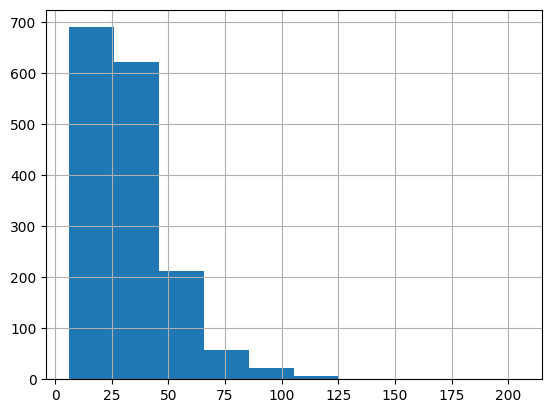

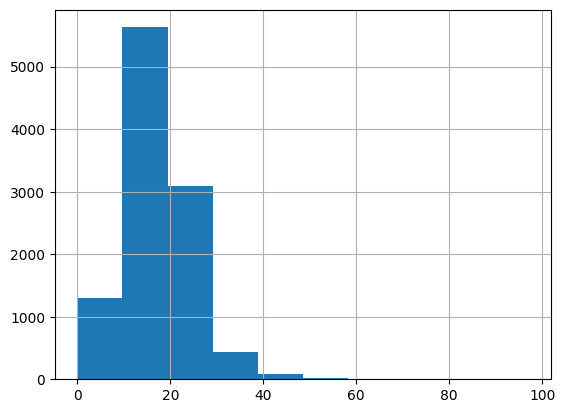

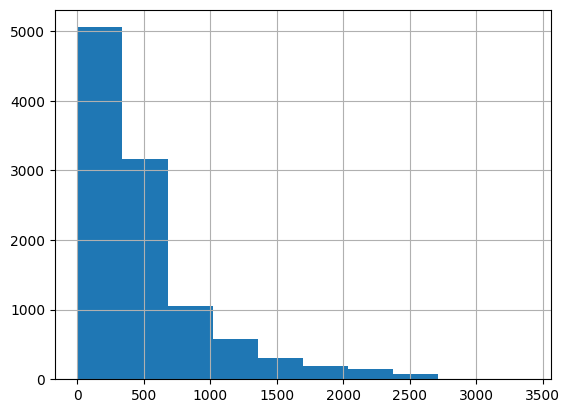

In [38]:
def tokenize_and_count(text):
    tokens = tokenizer.tokenize(text)
    return len(tokens)

df_train['sentence'].apply(tokenize_and_count).hist()
plt.show()
df_test['title'].apply(tokenize_and_count).hist()
plt.show()
df_test['text'].dropna().apply(tokenize_and_count).hist()
plt.show()

In [39]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(df_upsampled['label']), y=df_upsampled['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
class_weights

tensor([0.8703, 1.1751], device='cuda:0')

In [ ]:
class PROMPTEmbedding(nn.Module):
    def __init__(self,
                wte: nn.Embedding,
                n_tokens: int = 10,
                random_range: float = 0.5,
                initialize_from_vocab: bool = True):
        super(PROMPTEmbedding, self).__init__()
        self.wte = wte
        self.n_tokens = n_tokens
        self.learned_embedding = nn.parameter.Parameter(self.initialize_embedding(wte,
                                                                               n_tokens,
                                                                               random_range,
                                                                               initialize_from_vocab))

    def initialize_embedding(self,
                             wte: nn.Embedding,
                             n_tokens: int = 10,
                             random_range: float = 0.5,
                             initialize_from_vocab: bool = True):
        if initialize_from_vocab:
            return self.wte.weight[:n_tokens].clone().detach()
        return torch.FloatTensor(wte.weight.size(1), n_tokens).uniform_(-random_range, random_range)

    def forward(self, tokens):
        input_embedding = self.wte(tokens[:, self.n_tokens:])
        learned_embedding = self.learned_embedding.repeat(input_embedding.size(0), 1, 1)
        return torch.cat([learned_embedding, input_embedding], 1)

In [ ]:
# prompt_emb = PROMPTEmbedding(model.get_input_embeddings(),
#                       n_tokens=1,
#                       initialize_from_vocab=True)
# model.set_input_embeddings(prompt_emb)

In [ ]:
# prompt_tuning_config = PromptTuningConfig(
#     task_type=TaskType.CAUSAL_LM,

#     num_virtual_tokens=2,
#     token_dim=model.config.hidden_size
# )


# model = get_peft_model(model, prompt_tuning_config)

In [41]:
dataset = TextDataset(df_upsampled, tokenizer, max_len=125, device = device)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

Параметры обучения:

n_epochs = 4

lr=0.00005

Разморожены только последний энкодер и классификационная голова

In [44]:
model.to(device);
optimizer = Adam(model.parameters(), lr=0.00005)

n_epochs = 4

model.train()
running_loss = []

for epoch in range(n_epochs):
    epoch_loss = []
    for k,batch in enumerate(dataloader):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs.logits, labels)

        loss.backward()
        optimizer.step()

        running_loss.append(float(loss))
        epoch_loss.append(float(loss))
        if k%10 == 0:
            print(f"it: {k}, Loss: {np.mean(running_loss)}")
    print(f"Epoch: {epoch}, Loss: {np.mean(epoch_loss)}")

it: 0, Loss: 0.6908355951309204
it: 10, Loss: 0.7654951485720548
it: 20, Loss: 0.7239900628725687
it: 30, Loss: 0.7083190602640952
it: 40, Loss: 0.6917352153033745
it: 50, Loss: 0.6645767022581661
it: 60, Loss: 0.6311583992887716
it: 70, Loss: 0.6018357195065055
it: 80, Loss: 0.5687329820644709
it: 90, Loss: 0.5369370967804731
it: 100, Loss: 0.5144506449451541
it: 110, Loss: 0.4962917193099185
Epoch: 0, Loss: 0.49570596793241667
it: 0, Loss: 0.4933391988277435
it: 10, Loss: 0.4783708145618439
it: 20, Loss: 0.4646404887791033
it: 30, Loss: 0.4525839463903986
it: 40, Loss: 0.445005682399196
it: 50, Loss: 0.43081325631250034
it: 60, Loss: 0.4226429718094213
it: 70, Loss: 0.4097829133674905
it: 80, Loss: 0.40473444824799515
it: 90, Loss: 0.39897717560936763
it: 100, Loss: 0.3912891196650128
it: 110, Loss: 0.38437856727176245
Epoch: 1, Loss: 0.2676324445362154
it: 0, Loss: 0.3804214887776489
it: 10, Loss: 0.3719660759003342
it: 20, Loss: 0.3686191519969199
it: 30, Loss: 0.36322833308554525


In [45]:
X_test = X_test.reset_index(drop=True)

X_test['sentence'] = X_test['sentence'].apply(preprocess_for_bert)

In [71]:
def get_predictions_and_labels(model, l_dataloader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        t = time.time()
        for batch in l_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)



            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
        print(f'time {time.time() - t}')

    return predictions, true_labels


tdataset = TextDataset(X_test, tokenizer, max_len=125, device = device)
ttest_dataloader = DataLoader(tdataset, batch_size=1, shuffle=False)
# pred = get_predictions_and_labels(model, ttest_dataloader
predictions, true_labels = get_predictions_and_labels(model, ttest_dataloader)

f1 = f1_score(true_labels, predictions)
roc_auc = roc_auc_score(true_labels, predictions)
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average=None)
recall = recall_score(true_labels, predictions, average=None)

print(f"F1 Score: {f1}")
print(f"ROC-AUC Score: {roc_auc}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


time 5.261852979660034
F1 Score: 0.7883211678832117
ROC-AUC Score: 0.8901098901098902
Accuracy: 0.9102167182662538
Precision: [0.96385542 0.72972973]
Recall: [0.92307692 0.85714286]


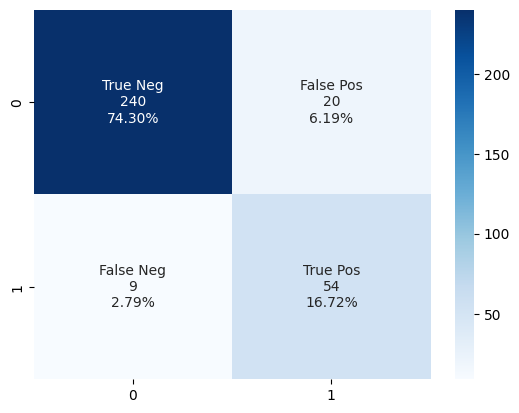

In [72]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
cm = confusion_matrix(true_labels, predictions)
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues');

In [98]:
def get_predictions_on_test(model, l_dataloader):
    model.eval()
    predictions = []

    with torch.no_grad():
        t = time.time()
        for batch in tqdm(l_dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            i_index = batch['index']
            orig_text = batch['orig_text']

            outputs = model(input_ids, attention_mask)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            positive_class_probs = probs[:, 1]
            positive_class_probs = positive_class_probs.cpu().numpy()
            predictions.append([int(i_index[0]), positive_class_probs[0]])

        print(f'time {time.time() - t}')

    return predictions

In [99]:
df_test_copy = df_test.reset_index().copy()
# df_test_copy['text'] = df_test_copy['text'].apply(preprocess_for_bert)
df_test_copy['text'] = df_test_copy['title'].apply(preprocess_for_bert)

In [100]:
tdataset = TextDatasetTest(df_test_copy, tokenizer, max_len=512, device = device)
ttest_dataloader = DataLoader(tdataset, batch_size=1, shuffle=False)
model.to(device);
pred = get_predictions_on_test(model, ttest_dataloader)

  0%|          | 0/10571 [00:00<?, ?it/s]

time 584.1137297153473


In [104]:
pred_df_test = pd.DataFrame(pred)
pred_df_test[pred_df_test[1]>=0.5].shape

(46, 2)

In [54]:
df_test['prediction'] = pred_df_test[1]
df_test = df_test.drop(['lemma_title','lemma_text'], axis=1)
df_test.to_csv('df_test_prediction.csv')

In [110]:
df_test[df_test['pred1']>=0.5]['title'].head(20).to_list()

['В Свердловской области отложат ввод налога для самозанятых',
 'Голубев выяснял, почему затянули реконструкцию трамвайных путей в Новочеркасске',
 'В «Титановой долине» сорваны сроки строительства здания таможни',
 'В Оренбурге приостановили проблемный ремонт тротуаров в центре города',
 'Прерванное три года назад строительство учебного центра МЧС в Иванове возобновят',
 'Реконструкция очистных сооружений в Рефтинском откладывается на год',
 '«Роскосмос» может отложить старт корабля с новогодними подарками для космонавтов - Корпорация "Человек"',
 'Сроки строительства дороги Неклюдово - Золотово перенесены на год',
 'Запуск первой в Турции атомной станции задерживается из-за проблем с финансированием',
 'Снежный покров в Москве задержится до четверга',
 'Открытие «московского Диснейленда» перенесли на 2020 год',
 'Строительство спортивного центра в Оби завершится в срок',
 '"Московская биржа" переносит покупку акций "Казахстанской фондовой биржи" на 2020 год',
 'Открытие «московского 

In [114]:
df_test_copy = df_test.reset_index().copy()
df_test_copy['text'] = df_test_copy['text'].apply(preprocess_for_bert)


In [ ]:
tdataset = TextDatasetTest(df_test_copy, tokenizer, max_len=512, device = device)
ttest_dataloader = DataLoader(tdataset, batch_size=1, shuffle=False)
model.to(device);
pred = get_predictions_on_test(model, ttest_dataloader)

___

<div style="border: 5px solid green; border-radius: 5px; padding: 10px;">
    
Для файнтюна использовалась XLM roberta large предобученная на русском корпусе. Основная модель была обрезана до 12 энкодеров, добавлена классификационная голова. Обучаемые слои: Последний энкодер, классификатор. Отдельно рассматривался подход с prompt-finetune. Он показал себя как дополнительный способ регуляризации, но не использовался в итоговой модели.

Также сравнивались различные модели (rubert, ruroberta, longformer для большого контекста), которые не показали улучшение в качестве. В качестве улучшения заслуживает внимание longformer с измененным формированием батча. Вместо одиночных данных стоит склеивать одно положительное предложение из обучающей выборки и несколько отрицательных, что должно помочь модели вычленять информацию из большого контекста.


### Llamma 3 8b prompting

Зададим промпт - fewshot learning для Llamma 3 8b

In [ ]:
class TextDataset(Dataset):
    def __init__(self, dataframe, ):

        self.data = dataframe
        self.text = dataframe['sentence']
        self.labels = dataframe['label']

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = self.text.iloc[index]

        label = torch.tensor(self.labels.iloc[index], dtype=torch.long)
        return {
            'label': label,
            'orig': get_prompt(text)
        }


In [ ]:
model_name = "Undi95/Meta-Llama-3-8B-hf"

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token_id = tokenizer.eos_token_id

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map='auto',
    low_cpu_mem_usage=True,
    quantization_config=quantization_config
)

In [ ]:
basic_prompt = """В предложениях содержится информация о задержке сдачи какого-либо объекта (информация есть - 1, информации нет - 0):
1) Срыв сроков строительства зоопарка оценили в 1 млрд рублей Управление капстроительства намерено взыскать в арбитраже 1 млрд руб. с АО "РЖДстрой" в качестве неустойки за срыв срока сдачи первой очереди зоопарка. -> 1;
2) Работы по достройке перинатального центра в Новосибирске могут быть завершены раньше запланированного срока на несколько месяцев. -> 0;
3) Это изменение нужно для того, чтобы полностью снять штрафные санкции с ТПЭ за срыв сроков ввода двух ТЭС в эксплуатацию. -> 1;
4) Временный запрет на регистрацию новых ДДУ никак не скажется и на ходе строительства ЖК "Балтийская жемчужина" в Красносельском районе, сообщил "Фонтанке" исполнительный директор компании-застройщика ЗАО "Рант" Дмитрий Шкрум. -> 0;
5) """


In [ ]:
def get_prompt(text):
    prompt = basic_prompt + text + ' -> '
    return prompt

In [ ]:
text = 'Возможный и допустимый срок задержки ввода в эксплуатацию новостройки составляет 2-3 месяца.'
prompt = get_prompt(text)

inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to("cuda")
outputs = model.generate(inputs.input_ids, max_length=inputs.input_ids.shape[1]+1)
generated_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

def extract_label(generated_text, prompt):
    return generated_text[len(prompt):].strip()


for i, generated_text in enumerate(generated_texts):
    pred = extract_label(generated_text, prompt)
    print(f"Predicted label: {pred}")


In [ ]:
def get_predictions_and_labels_lamma(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            orig = batch['orig']
            labels = batch['label']
            inputs = tokenizer(orig, return_tensors="pt", padding=True, truncation=True).to("cuda")
            outputs = model.generate(inputs.input_ids, max_length=inputs.input_ids.shape[1]+1)
            generated_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

            def extract_label(generated_text, prompt):
                return generated_text[len(prompt):].strip()
            
            preds = []
            for i, generated_text in enumerate(generated_texts):
                prompt = orig[i]
                pred = extract_label(generated_text, prompt)
                if pred and pred[0] == '1':
                    preds.append(1)
                else:
                    preds.append(0)

            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())
    return predictions, true_labels

dataset = TextDataset(X_test)
dataloader = DataLoader(dataset, batch_size=3, shuffle=False)
predictions, true_labels = get_predictions_and_labels_lamma(model, dataloader)

f1 = f1_score(true_labels, predictions)
roc_auc = roc_auc_score(true_labels, predictions)
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)

print(f"F1 Score: {f1}")
print(f"ROC-AUC Score: {roc_auc}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

F1 Score: 0.2824858757062147

ROC-AUC Score: 0.5289461781999096

Accuracy: 0.6197604790419161

Precision: 0.22522522522522523

Recall: 0.3787878787878788

___

<div style="border: 5px solid green; border-radius: 5px; padding: 10px;">
    
Использовалась  Llama3 8b черезе fewshot learning.
    
ROC-AUC = 0.53 -> модель практически случайно предсказывает метки. 
    
Вероятные ошибки:
    
    - предсказание метки не типовая задача для языковой модели
    
    - плохой промт
    
Решение:
    - prompt finetune - подобрать наилучший промт, который будет конкатиться к эмбедингам анализируемого текста

## Вывод

<div style="border: 5px solid blue; border-radius: 5px; padding: 10px;">

- Данные были изучены и предобработаны:
    - удаление дубликатов в трейне
    - замена пропусков на '' в тесте
    - определ дисбаланс классов
 
- Была проведена EDA:
    - текст был очищен и лемматизирован
    - было замечено, что среднее количество слов, предложений отличается в трейне и тесте
    - самые частые слова встречаются в обоих классах
    
- Использовался Countt-based подход:
    - tf-idf для векторизации
    - лучший результат catboost:
    
        F1 _______: 0.7123

        Precision_: 0.6265

        Recall____: 0.8254
    
- Использовался BERT для получения эмбедингов предложений и обучения на них линейной модели:
    - использовался ruBERT tiny (3 энкодера)
    - лучший результат SVC:
    
        F1 _______: 0.5913

        Precision_: 0.6538

        Recall____: 0.5397
    
- Также файнтюнился XLM roBERTa, обрезанная до 12 энкодеров:
    
    F1________: 0.7883211678832117

    Precision_:  0.72972973
    
    Recall____:  0.85714286
    
    
Итоговое предсказание получено на XLM roBERTa только с использованием `title`